In [ ]:
#==========================================
# Title:  Climate Credit Risk Model
# Author: Vachan
# Email : vachan@iitb.ac.in
#==========================================

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def find_best_logit_model(data, target_col, risk_drivers):
    """
    Iterates through all combinations of risk drivers to find the best logistic
    regression model based on BIC, trained on the entire dataset. Also checks
    for multicollinearity using VIF.

    Args:
        data (pd.DataFrame): The input dataframe.
        target_col (str): The name of the dependent variable (target).
        risk_drivers (list): A list of column names for the independent
                               variables (risk drivers).

    Returns:
        tuple: A tuple containing the best model's summary, the best
               combination of features, and the best BIC score.
    """
    best_model_summary = None
    best_combination = None
    # We want to minimize BIC, so we start with a very large number
    lowest_bic = float('inf')
    results = []

    print("--- Starting Model Search ---")

    # --- 1. Correlation Analysis ---
    print("\n--- Correlation Matrix of Risk Drivers ---")
    correlation_matrix = data[risk_drivers].corr()
    print(correlation_matrix)

    # Plotting the heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Risk Drivers')
    plt.show()
    print("-" * 40)

    # --- 2. Multicollinearity Check using VIF ---
    print("\n--- Variance Inflation Factor (VIF) Check ---")
    # VIF requires a constant, so we add one to our set of risk drivers
    X_for_vif = sm.add_constant(data[risk_drivers])
    
    # Create a dataframe to store VIF results
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_for_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i)
                       for i in range(X_for_vif.shape[1])]
    
    # We can ignore the VIF for the constant term
    print(vif_data[vif_data["feature"] != "const"])
    print("(Note: A VIF > 5 or 10 suggests potential multicollinearity)")
    print("-" * 55)


    # --- 3. Iterate through all combinations of risk drivers ---
    for i in range(1, len(risk_drivers) + 1):
        # Get all combinations of length i
        for combo in combinations(risk_drivers, i):
            combo_list = list(combo)
            print(f"\nTesting combination: {combo_list}")

            # Prepare the data for the full dataset
            X = data[combo_list]
            y = data[target_col]

            # Add a constant (intercept) to the model
            X = sm.add_constant(X)

            # --- 4. Build and Fit the Logistic Regression Model on the entire dataset ---
            try:
                logit_model = sm.Logit(y, X)
                result = logit_model.fit(disp=0) # disp=0 suppresses convergence messages

                # --- 5. Evaluate the Model using AIC and BIC ---
                aic_score = result.aic
                bic_score = result.bic
                pseudo_r_squared = result.prsquared

                print(f"  > AIC: {aic_score:.4f}")
                print(f"  > BIC: {bic_score:.4f}")
                print(f"  > Pseudo R-squared: {pseudo_r_squared:.4f}")

                results.append({
                    'Combination': combo_list,
                    'AIC': aic_score,
                    'BIC': bic_score,
                    'Pseudo_R_squared': pseudo_r_squared
                })

                # --- 6. Identify the Best Model (lower BIC is better) ---
                if bic_score < lowest_bic:
                    lowest_bic = bic_score
                    best_model_summary = result.summary()
                    best_combination = combo_list

            except Exception as e:
                print(f"Could not fit model for combination {combo_list}. Error: {e}")

    print("\n--- Model Search Complete ---")

    # --- 7. Display all results ---
    # Sort results by BIC (ascending) to see the best models at the top
    results_df = pd.DataFrame(results).sort_values(by='BIC', ascending=True).reset_index(drop=True)
    print("\n--- All Model Combination Results (sorted by BIC) ---")
    print(results_df)
    print("-" * 65)


    return best_model_summary, best_combination, lowest_bic


In [1]:
# --- Main Execution ---
if __name__ == '__main__':
    # Load the dataset
    try:
        # Load the provided CSV file
        df = pd.read_csv("C:/Users/vacha/OneDrive - Indian Institute of Technology Bombay/Climate Finance/Retail Portfoilio Research/Auto Risk Kaggle/data.csv")
        # --- Define Risk Drivers and Target ---
        # You can easily change this vector for a new dataset
        risk_driver_vector = [
            'ltv',
            'disburse_to_sactioned_ratio',
            'average_age', 'credit_score', 'last_six_month_defaulted_no', 'credit_history', 'main_account_tenure'
        ]
        target_variable = 'loan_default'

        # Ensure all specified columns exist in the dataframe
        all_cols = risk_driver_vector + [target_variable]
        if not all(col in df.columns for col in all_cols):
            raise ValueError("One or more specified columns are not in the DataFrame.")

        # Drop rows with missing values in the relevant columns for simplicity
        df.dropna(subset=all_cols, inplace=True)
        
        # Make sure target variable is integer type
        df[target_variable] = df[target_variable].astype(int)
    except FileNotFoundError:
        print("Error: The file 'Datagpt.xlsx - Sheet1.csv' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

        


An error occurred: name 'pd' is not defined


--- Starting Model Search ---

--- Correlation Matrix of Risk Drivers ---
                                  ltv  disburse_to_sactioned_ratio  \
ltv                          1.000000                     0.000960   
disburse_to_sactioned_ratio  0.000960                     1.000000   
average_age                  0.026931                     0.007467   
credit_score                 0.087051                     0.001441   
last_six_month_defaulted_no  0.041653                     0.001267   
credit_history               0.053918                     0.004896   
main_account_tenure         -0.001319                     0.048154   

                             average_age  credit_score  \
ltv                             0.026931      0.087051   
disburse_to_sactioned_ratio     0.007467      0.001441   
average_age                     1.000000      0.468580   
credit_score                    0.468580      1.000000   
last_six_month_defaulted_no     0.172883      0.162263   
credit_history   

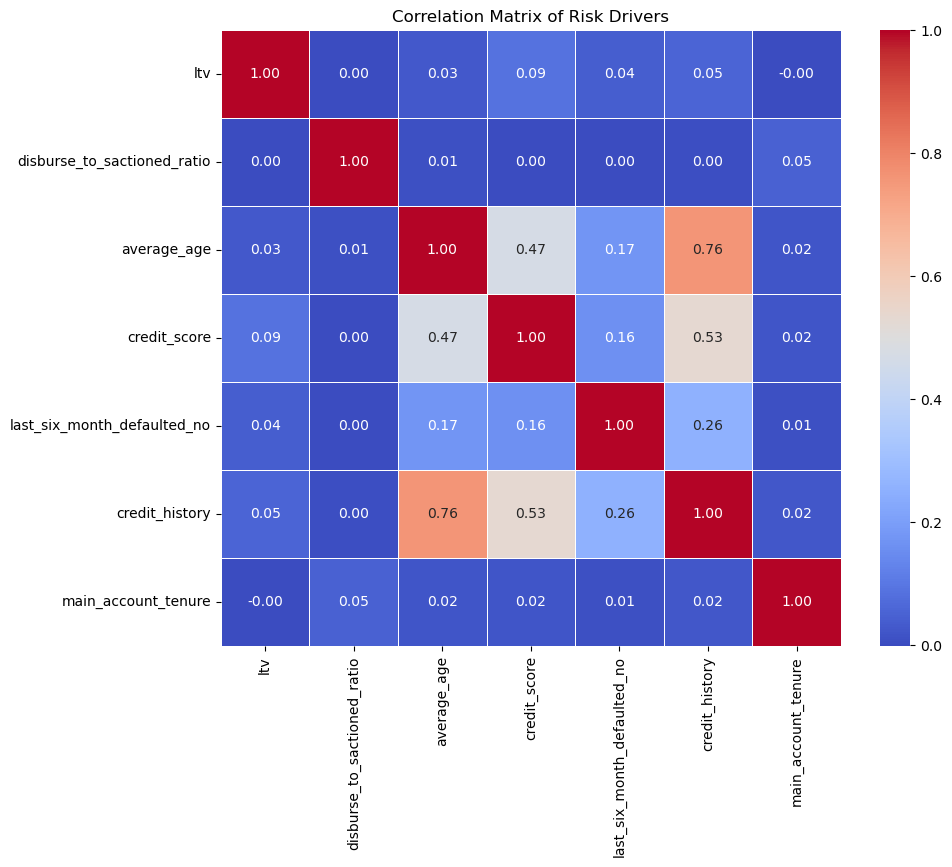

----------------------------------------

--- Variance Inflation Factor (VIF) Check ---
                       feature       VIF
1                          ltv  1.009289
2  disburse_to_sactioned_ratio  1.002377
3                  average_age  2.394455
4                 credit_score  1.424438
5  last_six_month_defaulted_no  1.073725
6               credit_history  2.686913
7          main_account_tenure  1.003025
(Note: A VIF > 5 or 10 suggests potential multicollinearity)
-------------------------------------------------------

Testing combination: ['ltv']
  > AIC: 184925.4746
  > BIC: 184945.8839
  > Pseudo R-squared: 0.0095

Testing combination: ['disburse_to_sactioned_ratio']
  > AIC: 186704.2005
  > BIC: 186724.6098
  > Pseudo R-squared: 0.0000

Testing combination: ['average_age']
  > AIC: 186597.2863
  > BIC: 186617.6957
  > Pseudo R-squared: 0.0006

Testing combination: ['credit_score']
  > AIC: 186123.4904
  > BIC: 186143.8997
  > Pseudo R-squared: 0.0031

Testing combination: 

In [15]:
# Find the best mode
summary, combination, bic = find_best_logit_model(df, target_variable, risk_driver_vector)

# Print the final results
print("\n\n--- Best Model Found ---")
print(f"The best combination of risk drivers (based on lowest BIC) is: {combination}")
print(f"Best Model's BIC Score: {bic:.4f}")
print("\n--- Best Model Summary ---")
print(summary)

    